In [17]:
import xarray
from GliderTools import glidertools as gt
from download_glider_data import utils
import dictionaries
from matplotlib import pyplot as plt
import numpy as np
import cmocean


### Major switch between lines/processing:

In [18]:
dataset = 'NS1' 

In [19]:
# execute this cell only to use Bastiens gridded Glider data!
if dataset=='bastiens_gridded_data':
    ds = xarray.open_dataset('../data/input/methane_processed_bastien/timeseries_output.nc')
    ds['meantimes'] = gt.utils.time_average_per_dive(ds.profile_num, ds.time)
    ds['dives'] = ds['profile_num']
    dso = ds
    def mld_profile(df, variable, thresh, ref_depth, verbose=True):
        exception = False
        divenum = df.index[0]
        df = df.dropna(subset=[variable, "depth"])
        if len(df) == 0:
            mld = np.nan
            exception = True
            message = """no observations found for specified variable in dive {}
                    """.format(
                divenum
            )
        elif np.nanmin(np.abs(df.depth.values - ref_depth)) > 5:
            exception = True
            message = """no observations within 5 m of ref_depth for dive {}
                    """.format(
                divenum
            )
            mld = np.nan
        else:
            direction = 1 if np.unique(df.index % 2 != 0) else -1
            # create arrays in order of increasing depth
            var_arr = df[variable].values[:: int(direction)]
            depth = df.depth.values[:: int(direction)]
            # get index closest to ref_depth
            i = np.nanargmin(np.abs(depth - ref_depth))
            # create difference array for threshold variable
            dd = var_arr - var_arr[i]
            # mask out all values that are shallower then ref_depth
            dd[depth < ref_depth] = np.nan
            # get all values in difference array within treshold range
            mixed = dd[abs(dd) > thresh]
            if len(mixed) > 0:
                idx_mld = np.argmax(abs(dd) > thresh)
                mld = depth[idx_mld]
            else:
                exception = True
                mld = np.nan
                message = """threshold criterion never true (all mixed or \
                    shallow profile) for profile {}""".format(
                    divenum
                )
        if verbose and exception:
            warnings.warn(message, category=GliderToolsWarning)
        return mld
    # monkey patch
    gt.physics.mld_profile = mld_profile
else: 
    dsids = ['delayed_'+item for item in dictionaries.timelines[dataset]]#['NS_1']]
    dsdict = utils.download_glider_dataset(dataset_ids=dsids)
    datasets_list = [ds[np.array(list(ds))[
        np.array([np.issubdtype(ds[variable].dtype, np.floating) for variable in list(ds)]
                )]] for ds in [*dsdict.values()]]

    ds = gt.load.voto_concat_datasets(datasets_list)
    ds['meantimes'] = gt.utils.time_average_per_dive(ds.profile_num, ds.time)
    dso = ds
    
    ds = dso.isel(time=slice(0,-1,10), drop=True)
    ds = ds.where(abs(np.gradient(ds.depth))>0.5)

Found delayed_SEA077_M11 in voto_erddap_data_cache. Loading from disk
Found delayed_SEA069_M11 in voto_erddap_data_cache. Loading from disk
Found delayed_SEA077_M13 in voto_erddap_data_cache. Loading from disk
Found delayed_SEA045_M69 in voto_erddap_data_cache. Loading from disk
Found delayed_SEA077_M15 in voto_erddap_data_cache. Loading from disk
Found delayed_SEA045_M71 in voto_erddap_data_cache. Loading from disk
Found delayed_SEA077_M17 in voto_erddap_data_cache. Loading from disk
Found delayed_SEA045_M73 in voto_erddap_data_cache. Loading from disk


/media/coffee/T7/Nordstream/code/GliderTools/glidertools/helpers.py:97: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xds = xr.DataArray(


In [26]:
import pandas as pd
import numpy as np
def halocline(df):
    df = df[df.depth>5]
    df = df.dropna(subset=["salinity", "depth"])
    if len(df.time) < 2:
        hdepth = np.nan
        exception = True
    elif np.nanmax(df.depth.values) < 40:
        exception = True
        hdepth = np.nan
    else:
        hdepth = df.depth.iloc[np.argmax(np.gradient(df.salinity, df.depth))]
    return hdepth

def thermocline(df):
    df = df[df.depth>10]
    df = df.dropna(subset=["temperature", "depth"])
    windowlength = 20
    if len(df.time) < 2:
        hdepth = np.nan
        exception = True
    elif np.nanmax(df.depth.values) < 40:
        exception = True
        hdepth = np.nan
    elif len(df.time) <= windowlength:
        exception = True
        hdepth = np.nan
    else:
        # bugs out if (remaining) profile is shorter than window length
        try:
            df['temperature'] = df['temperature'].rolling(window=windowlength, center=True, min_periods=1).mean()
            hdepth = df.depth.iloc[np.nanargmax(abs(np.gradient(df.temperature, df.depth)))]
        except:
            import pdb; pdb.set_trace();

    return hdepth

def isoline(df, variable, isovalue):
    df = df[df.depth>5]
    df = df.dropna(subset=[variable, "depth"])
    if len(df.time) < 2:
        # drop very short, incomplete profiles
        hdepth = np.nan
        exception = True
    elif np.nanmax(df.depth.values) < 40:
        # drop shallow profiles
        exception = True
        hdepth = np.nan
    else:
        hdepth = df.depth.iloc[np.argmin(abs(df[variable]-isovalue))]
    return hdepth

def unaggregated_mean(group, in_variable, out_variable):
    c = group[in_variable].mean()
    group[out_variable] = c
    return group

groups = gt.utils.group_by_profiles(ds)


In [36]:
tcline = groups.apply(thermocline)

In [62]:
lcline = groups.apply(halocline)
mld = gt.physics.mixed_layer_depth(ds, 'potential_density', thresh=0.03, verbose=False, ref_depth=10)
times = groups.mean().time
psu12isohaline = groups.apply(isoline, 'salinity', 10)

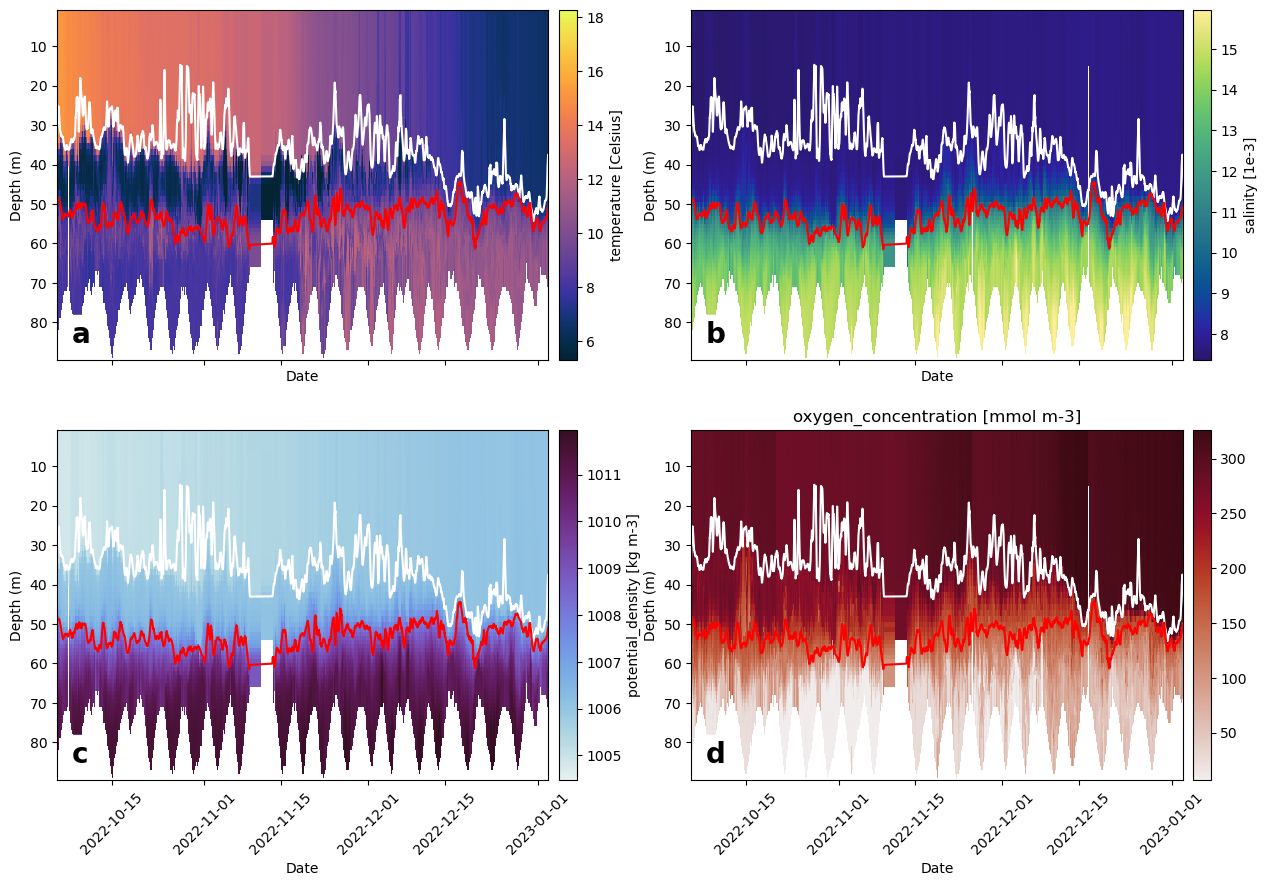

In [69]:
import string
fig, axs = plt.subplots(figsize=[15,10], nrows=2, ncols=2, sharex='col')
gt.plot(ds.meantimes, ds.depth, ds.temperature, ax=axs[0,0], cmap=cmocean.cm.thermal)
gt.plot(ds.meantimes, ds.depth, ds.salinity, ax=axs[0,1], cmap=cmocean.cm.haline)
gt.plot(ds.meantimes, ds.depth, ds.potential_density, ax=axs[1,0], cmap=cmocean.cm.dense)
gt.plot(ds.meantimes, ds.depth, ds.oxygen_concentration, ax=axs[1,1], cmap=cmocean.cm.amp)

if dataset in ['bastiens_gridded_data', 'NS_methane_sensor']:
    times_cut = times.where(
        (times<np.datetime64('2022-10-30')) |
        (times>np.datetime64('2022-11-15'))
        )
else:
    times_cut = times

# process smooth mld, lcline and tcline
dfmld = pd.DataFrame(data=dict(mld=mld, time=times))
dflcline = pd.DataFrame(data=dict(lcline=lcline, time=times_cut))
dftcline = pd.DataFrame(data=dict(tcline=tcline, time=times))

for index, ax in enumerate(axs.flatten()):
    ax.plot(times, mld.rolling(window=30, min_periods=3).mean(), color='white', alpha=1)
    ax.plot(times_cut, lcline.rolling(window=50, min_periods=3).mean(), color='red', alpha=1)
    ax.set_xlim(np.datetime64('2022-10-05'), np.datetime64('2023-01-03'))
    ax.text(0.03, 0.05, string.ascii_lowercase[index], transform=ax.transAxes, 
            size=20, weight='bold', zorder=100, backgroundcolor='white')

    plt.savefig('../figures/supplementary_SAMBA')

